# CatBoost Final Model

In [1]:
# Imports
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel('data/churn_df_data_categorical.xlsx')

## Partition our Data and Pre-processing.

In [3]:
Y = (df["left_flag"] == "Yes") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag"])

In [4]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 26), (1691, 26))

## Training and Fitting the Model

In [5]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cat_cols = ['has_dependents',
 'home_phone',
 'multi_line',
 'contract_term',
 'e_bill_opt_in',
 'pay_method',
 'gender',
 'is_married',
 'recent_offer',
 'internet_tech',
 'unlimited_data_opt']  


cat_pipe = Pipeline([
    ("model", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=99,
        verbose=0,
        allow_writing_files=False 
    ))
])

param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.01, 0.03],
    "model__iterations": [400, 800],
    "model__l2_leaf_reg": [1, 3, 10],

}

cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    return_train_score=True 
)

cat_cv.fit(X_train, Y_train, model__cat_features=cat_cols)

best_model = cat_cv.best_estimator_
print(cat_cv.best_params_)

{'model__depth': 4, 'model__iterations': 400, 'model__l2_leaf_reg': 10, 'model__learning_rate': 0.03}


## Evaluating the Model

In [7]:
from sklearn.metrics import roc_auc_score

best_model = cat_cv.best_estimator_   # pipeline with ("model", CatBoostClassifier)


#printing both AUC (Training and Validation to check the AUC stability)
cv_results = pd.DataFrame(cat_cv.cv_results_)
best_idx = cat_cv.best_index_

# ✅ Training + Validation AUC (from CV)
print(f"Training AUC (CV avg):   {cv_results.loc[best_idx, 'mean_train_score']:.3f}")
print(f"Validation AUC (CV avg): {cv_results.loc[best_idx, 'mean_test_score']:.3f}")


y_test_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(Y_test, y_test_proba)
print(f"CatBoost (tuned) Test AUC: {auc:.3f}")

Training AUC (CV avg):   0.881
Validation AUC (CV avg): 0.850
CatBoost (tuned) Test AUC: 0.837


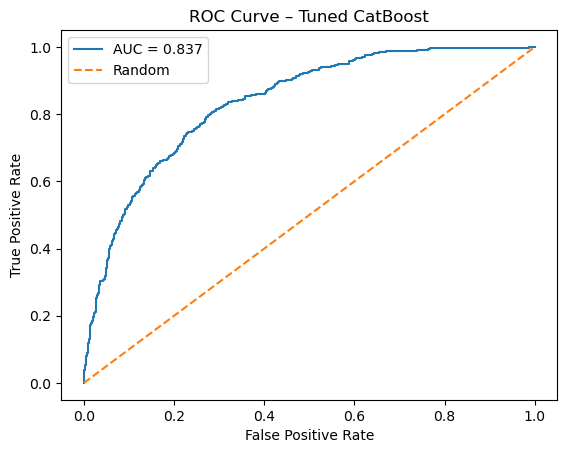

In [8]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned CatBoost")
plt.legend()
plt.show()


Test PR-AUC: 0.6406


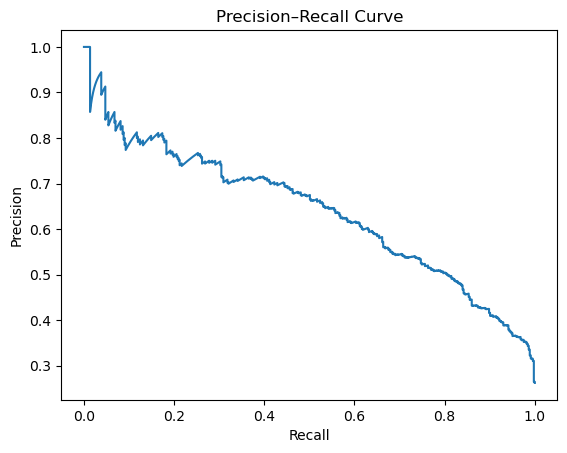

In [9]:
# precision

from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(Y_test, y_test_proba)
print("Test PR-AUC:", round(pr_auc, 4))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(Y_test, y_test_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

## Feature Importance

In [10]:
cb = best_model.named_steps["model"]   
importances = cb.get_feature_importance()  

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
4,contract_term,22.746737
1,tenure_mo,15.208419
14,internet_tech,10.066597
7,monthly_fee,9.306180
6,pay_method,6.993403
19,num_add_ons,5.172484
18,long_dist_fees_total,4.539201
8,total_billed,3.812772
15,avg_gb_download,3.017861
10,age_years,2.319943


In [11]:
best_model.named_steps.keys()

dict_keys(['model'])

In [12]:
import matplotlib.pyplot as plt
from catboost import Pool

# 1) Get best fitted CatBoost model from GridSearchCV pipeline
best_cb = cat_cv.best_estimator_.named_steps["model"]

# 2) Use test data 
X_imp = X_test.copy()

# 3) Identify categorical columns
cat_cols = X_imp.select_dtypes(include=["object", "category"]).columns.tolist()

pool = Pool(X_imp, cat_features=cat_cols)

# 4) Get DEFAULT CatBoost feature importance
importances = best_cb.get_feature_importance(
    pool,
    type="PredictionValuesChange" 
)

# 5) Create sorted importance table
imp = (
    pd.Series(importances, index=X_imp.columns)
    .sort_values(ascending=False)
)

display(imp.head(20))

contract_term                   22.728975
tenure_mo                       15.633020
internet_tech                    9.765797
monthly_fee                      9.025370
pay_method                       6.700068
num_add_ons                      5.539878
long_dist_fees_total             4.571979
total_billed                     3.926667
avg_gb_download                  3.047026
age_years                        2.577208
has_streaming                    2.272806
e_bill_opt_in                    2.124061
recent_offer                     1.990220
unexpected_cost_burden_ratio     1.778971
has_dependents                   1.399942
overage_ratio_avg                1.380914
avg_long_dist_fee                1.245144
extra_data_fees_total            1.243050
multi_line                       1.128068
unlimited_data_opt               1.005366
dtype: float64

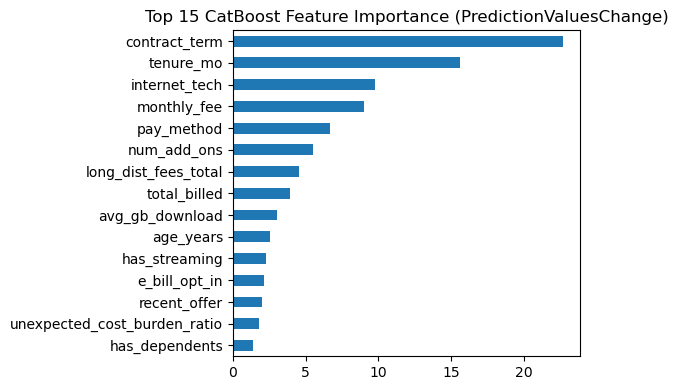

In [13]:
# 6) Plot top 15
imp.head(15).sort_values().plot(
    kind="barh",
    figsize=(6, 4),
    title="Top 15 CatBoost Feature Importance (PredictionValuesChange)"
)

plt.tight_layout()
plt.show()

In [19]:
# 1) Choose your SHAP dataset
X_shap = X_test.copy()
X_shap = X_shap.sample(min(1000, len(X_shap)), random_state=42)

# 2) CatBoost-native SHAP values
shap_vals = best_cb.get_feature_importance(pool, type="ShapValues")

# 3) shap_vals shape = (n_rows, n_features + 1). Last column = expected value
shap_values = shap_vals[:, :-1]

# 4) Mean(|SHAP|) feature importance
imp = pd.Series(np.abs(shap_values).mean(axis=0), index=X_shap.columns).sort_values(ascending=False)

display(imp.head(20))

contract_term                   0.636378
tenure_mo                       0.364346
monthly_fee                     0.340798
internet_tech                   0.312531
pay_method                      0.305085
long_dist_fees_total            0.166854
num_add_ons                     0.148747
e_bill_opt_in                   0.109404
has_streaming                   0.100185
total_billed                    0.095200
age_years                       0.070718
avg_gb_download                 0.044392
has_dependents                  0.040312
multi_line                      0.033254
unexpected_cost_burden_ratio    0.027163
unlimited_data_opt              0.026533
extra_data_fees_total           0.026384
overage_ratio_avg               0.021440
recent_offer                    0.020017
has_add_on                      0.016578
dtype: float64

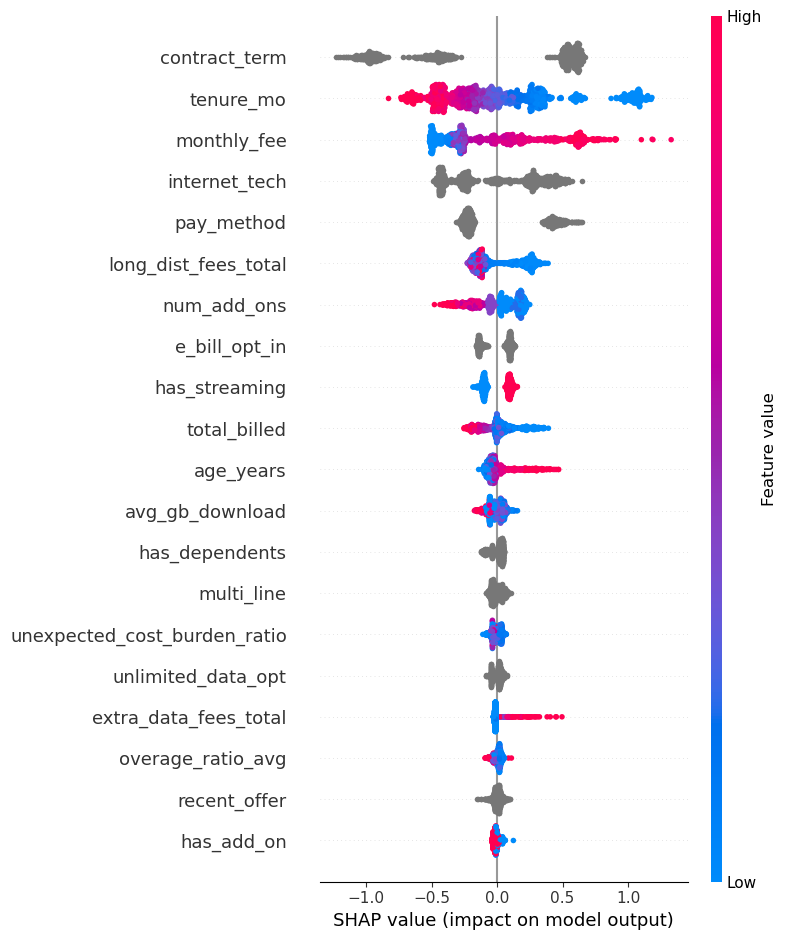

In [20]:
# 6) Plot top 20
import shap

shap.summary_plot(shap_values, X_shap, max_display=20, show=True)

In [21]:
assert shap_values.shape[1] == X_shap.shape[1], "Mismatch: shap_values columns != X_shap columns"

# Red - high,  Blue - low 
# More dots right - Higher churn 
# More dots left - Lower churn 
# dots - each data point 